In [1]:
# import pandas as pd
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
directory = "C:\AB_Test_Results.xlsx"
df = pd.read_excel(directory, header=0)

In [3]:
df.sort_values("USER_ID", inplace = True)
df.reset_index(inplace=True, drop=True)
df.info() #check for missing data
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
USER_ID         10000 non-null int64
VARIANT_NAME    10000 non-null object
REVENUE         10000 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 195.4+ KB


,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,2,control,0.0
2,2,control,0.0
3,3,variant,0.0
4,3,variant,0.0
5,3,control,0.0
6,4,variant,0.0
7,5,variant,0.0
8,6,variant,0.0
9,9,variant,0.0


We are not dealing with crossover plans, where same units get different treatments over a period of time. So, for the purpose of this example we discard units with treatment/control intersections. We are not addressing how to deal with these intersections, we assume random sampling and no interference.

In [4]:
# count treatments for user_id
df_gr=df.groupby('USER_ID')['VARIANT_NAME'].nunique().reset_index()
df_gr.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [5]:
# find re-used user_ids and remove them
df_to_del = df_gr.loc[df_gr.VARIANT_NAME > 1, ['USER_ID']]
df_mg = pd.merge(df, df_to_del, how='left', on='USER_ID', indicator=True)
df_corr = df_mg.loc[df_mg._merge == 'left_only', ['USER_ID', 'VARIANT_NAME', 'REVENUE']]
df_corr.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,2,control,0.0
2,2,control,0.0
6,4,variant,0.0
7,5,variant,0.0
8,6,variant,0.0
9,9,variant,0.0
12,11,control,0.0
13,11,control,0.0
14,12,control,0.0


In [6]:
#summary stats
df_corr.groupby("VARIANT_NAME")["REVENUE"].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,3026.0,0.155506,3.708620,0.0,0.0,0.0,0.0,196.01
variant,3044.0,0.058909,0.760344,0.0,0.0,0.0,0.0,23.04


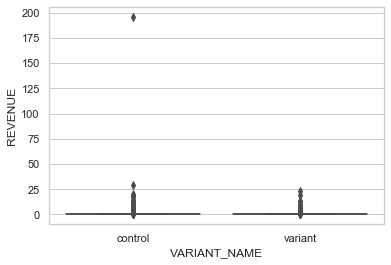

In [7]:
#box-plot
sns.set(style="whitegrid")
sns.boxplot(x='VARIANT_NAME',y='REVENUE',data=df_corr)

Distributions of REVENUE for both groups are asymetric. The fact that $\gt 75\%$ of observations are zeros tells us that the very event of REVENUE is rare. One option could be to work directly with both variant and control distributions of REVENUE. In this case one should try normalizing them or model them as a mixture of symetric and asymetric parts. However, we choose to work with the rare events of REVENUE in a simpler form such as Poisson distribution. Although, ZIPR (zero inflated poisson) could probably fit  better we restrict ourselves with a simple Poisson distribution. 

Suppose that the data-generation follows $ X_{test} \sim Poisson(\lambda_1) $  and  $ X_{control} \sim Poisson(\lambda_2)$ 

In [8]:
#recode REVENUE as binary variable (convert / non-convert) 
#to represent Poisson counts per unit of exposure
df_corr['convert'] = df_corr.REVENUE.apply(lambda x: 1 if x > 0.00  else 0)
df_corr.groupby("VARIANT_NAME")["convert"].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,3026.0,0.017845,0.132411,0.0,0.0,0.0,0.0,1.0
variant,3044.0,0.014126,0.118030,0.0,0.0,0.0,0.0,1.0


To illustrate why convertion events are rare we need to estimate both lambdas as 
$\hat{\lambda} = \frac{\sum{successes}}{total \ exposure}$  

In [9]:
dff=df_corr.groupby("VARIANT_NAME")["USER_ID"].count().reset_index()
n = dff.loc[dff["VARIANT_NAME"]=='variant']["USER_ID"].values[0]
m = dff.loc[dff["VARIANT_NAME"]=='control']["USER_ID"].values[0]
dff_s=df_corr.groupby("VARIANT_NAME")["convert"].sum().reset_index()
s1= dff_s.loc[dff["VARIANT_NAME"]=='variant']["convert"].values[0]
s2= dff_s.loc[dff["VARIANT_NAME"]=='control']["convert"].values[0]
print("Sample size test (n): % 2d" %(n) )  
print("Sample size control (m): % 2d" %(m) )  
print("Successes test: % 2d" %(s1))  
print("Successes control: % 2d" %(s2))  

Sample size test (n):  3044
Sample size control (m):  3026
Successes test:  43
Successes control:  54


Because we sample our $iid$ variables from $Poisson(\lambda)$ _n_ and _m_ times we can use these  sample sizes as exposures for both groups. Therefore, $\hat{\lambda_1} = \frac{43}{3044} = 0.014$ and $\hat{\lambda_2} = \frac{54}{3026} = 0.018$.

From these rate estimates we can see that  we expect (on average) per each unit of exposure (i.e. per each user) about $1\%$ of conversions. _Pro rata temporis_ we expect (on average) 43 conversions per 3044 units of exposure and 53 per 3026 in test and control groups respctively. 

This summation of successes is due to the fact that: 
* $X_{1},X_{2},...,X_{n}$ are _iid_ $Poisson(\lambda)$, then $X = \sum_{i=1}^{n} X_{i} \sim Poisson(n\lambda)$

This fact can be used to from hypotheses.
* First, rewrite  the parameters as $\lambda_1,\lambda_2$ как $ r_1 = n\lambda_1, r_2 = m\lambda_2$ 
* Then define $\theta = \frac{\lambda_1}{\lambda_2}$
* Then, it is well known that if $ X_{test} \sim {Poisson(r_1)} $ and  $ X_{control} \sim {Poisson(r_2)} $ are independent, then
$ X_{test}  \lvert  X_{test} + X_{control} =  k \sim {Binomial(k,p(\theta))} $, где k=number of trials and 
$p(\theta) = \frac{r_1}{r_1 + r_2}$.
* $\lambda_1= \theta\lambda_2 $, it follows that $\frac{r_1}{r_1 + r_2}$ 
    = $\frac{n\theta\lambda_2}{n\theta\lambda_2 + m\lambda_2} = \frac{n\theta}{n\theta + m}$
* Now, under $H_0: \theta=\frac{\lambda_1}{\lambda_2} \leq 1 <=> p(\theta)\leq \frac{n}{n+m}$ and 
$H_a: \theta=\frac{\lambda_1}{\lambda_2} \gt 1 <=> p(\theta)\gt \frac{n}{n+m}$

In [10]:
pi=n/(n+m)
print("Proportion of succeses under H_0 : % 5f" %(pi) )  

Proportion of succeses under H_0 :  0.501483


In [11]:
p_val=scipy.stats.binom_test(s1,s1+s2,pi,alternative="greater")
print("P_value of the test : % 5f" %(p_val))  

P_value of the test :  0.894013


With this data we can not reject the $H_0$ which can be translated as "the ratio of two Poisson rates is not statistically different from 1". So, the conversion rates are basically the same and our experiment hasn't shown any effectiveness of the test variant over the control variant. 